###Bidirectional LSTM
The objective of this experiment is to build and evaluate an advanced LSTM model variant (Bidirectional LSTM) for Remaining Useful Life (RUL) prediction in the C-MAPSS dataset. Unlike standard LSTM, the bidirectional version learns forward and backward temporal dependencies, making it more effective for sequence prediction.

###1. Imports Necessary Libraries

In [ ]:
# Core libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Deep learning (TensorFlow / Keras)
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Bidirectional, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau


###2. Data Loading

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Load rolling window sequences (shape: [num_samples, window_size, num_features])
X = np.load("/content/drive/MyDrive/Dataset of ai/rolling_window_sequnces_1.npy")      # Feature array
# Load metadata that contains engine_id, cycle, RUL, etc.
metadata = pd.read_csv("/content/sequence_metadata_with_RUL (1).csv")
y = metadata["RUL"].values                     # Target RUL array

# Print shapes to verify
print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (17631, 30, 66)
y shape: (17631,)


###3. Train/Validation Split

In [ ]:
# Split into Training and Validation Sets
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)
print("Train shape:", X_train.shape, y_train.shape)
print("Val shape:", X_val.shape, y_val.shape)

# Inspect sample batches
print("Example X_train[0] batch shape:", X_train[0].shape)
print("First 5 RUL targets:", y_train[:5])

Train shape: (14104, 30, 66) (14104,)
Val shape: (3527, 30, 66) (3527,)
Example X_train[0] batch shape: (30, 66)
First 5 RUL targets: [ 74.  41.  43.  33. 101.]


In [ ]:
# Data Pipeline / Generator (optional, for very large data)
# Keras can accept Numpy arrays directly in fit(), so for most practical cases, we can skip writing a custom generator
# If memory is a concern, use tf.data.Dataset.from_tensor_slices
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(64).prefetch(1)
val_dataset   = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(64).prefetch(1)

###4. Bidirectional LSTM Model-Model Architecture




In [ ]:

# Bidirectional LSTM layer to capture forward and backward temporal dependencies
def build_bidirectional_lstm_model(input_shape, lstm_units=64, dropout_rate=0.3):
    model = Sequential([
        Bidirectional(LSTM(lstm_units, activation='tanh', return_sequences=False),
                      input_shape=input_shape),
        Dropout(dropout_rate),
        Dense(1)
    ])
    return model


###5. Instantiate and Compile Models

In [ ]:
model = build_bilstm(input_shape=(X_train.shape[1], X_train.shape[2]))
model.compile(optimizer=tf.keras.optimizers.Adam(0.001), loss='mse', metrics=['mae'])
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_3 (Bidirectional) │ (None, 128)            │        67,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 71,233 (278.25 KB)

 Trainable params: 71,233 (278.25 KB)

 Non-trainable params: 0 (0.00 B)

###6. Prepare Datasets for Training

In [ ]:
# Convert to TensorFlow dataset for efficiency
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(64).shuffle(1000)
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(64)


###7. Setup Callbacks

In [ ]:
# Training Setup: Callbacks
early_stop = EarlyStopping(
    monitor='val_loss', patience=8, restore_best_weights=True, verbose=1
)
reduce_lr = ReduceLROnPlateau(
    monitor="val_loss", factor=0.5, patience=4, min_lr=1e-5, verbose=1
)
model_ckpt = ModelCheckpoint(
    "best_lstm_model.keras", save_best_only=True, monitor="val_loss", verbose=1
)


###8. Train and Compare Models

In [ ]:

# Model Training
history = model.fit(
    train_dataset,
    epochs=50,
    validation_data=val_dataset,
    callbacks=[early_stop, reduce_lr, model_ckpt]
)


Epoch 1/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 5237.7949 - mae: 59.0082
Epoch 1: val_loss improved from inf to 412.51999, saving model to best_lstm_model.keras
221/221 ━━━━━━━━━━━━━━━━━━━━ 15s 50ms/step - loss: 5226.3389 - mae: 58.9161 - val_loss: 412.5200 - val_mae: 16.5111 - learning_rate: 0.0010
Epoch 2/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 416.6314 - mae: 16.3208
Epoch 2: val_loss improved from 412.51999 to 263.46384, saving model to best_lstm_model.keras
221/221 ━━━━━━━━━━━━━━━━━━━━ 19s 41ms/step - loss: 416.4933 - mae: 16.3177 - val_loss: 263.4638 - val_mae: 12.8204 - learning_rate: 0.0010
Epoch 3/50
220/221 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 303.5054 - mae: 13.5923
Epoch 3: val_loss improved from 263.46384 to 213.46884, saving model to best_lstm_model.keras
221/221 ━━━━━━━━━━━━━━━━━━━━ 11s 47ms/step - loss: 303.3639 - mae: 13.5886 - val_loss: 213.4688 - val_mae: 11.1961 - learning_rate: 0.0010
Epoch 4/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/st

###9. Plot Training and Validation Loss Curve

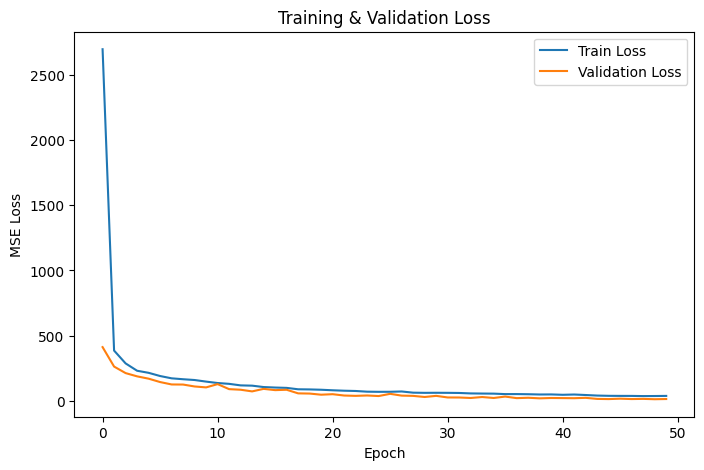

In [ ]:
# Training and Validation Curves
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()
plt.show()

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step


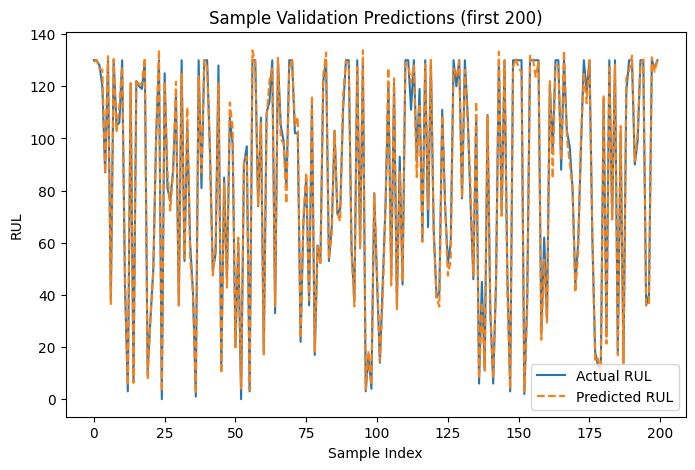

In [ ]:
# Verify Model Predictions
val_pred = model.predict(X_val[:200]).flatten()
plt.figure(figsize=(8,5))
plt.plot(y_val[:200], label='Actual RUL')
plt.plot(val_pred, label='Predicted RUL', linestyle='--')
plt.title('Sample Validation Predictions (first 200)')
plt.xlabel('Sample Index')
plt.ylabel('RUL')
plt.legend()
plt.show()

##Overview

This notebook demonstrates the complete pipeline for preparing time-series data and training a Bidirectional LSTM neural network to predict the Remaining Useful Life (RUL) of turbofan engines using NASA's CMAPSS dataset. The rolling window sequences capture temporal dependencies across engine sensor readings, and the Bidirectional LSTM leverages both forward and backward time dynamics for more accurate predictions. This process supports predictive maintenance by forecasting machinery health and enabling proactive intervention before failures occur.

##Data Preparation

Loaded preprocessed rolling window sequences (rolling_window_sequnces_1.npy) representing sensor features over 30-cycle windows.

Loaded sequence metadata (sequence_metadata_with_RUL (1).csv) containing engine IDs, cycle numbers, and computed RUL targets.

Split data into training (80%) and validation (20%) sets, ensuring shape consistency and alignment between features and labels.

Created TensorFlow datasets for efficient batching and shuffling during model training.

##Final Report of Experiment

##Model Used:
 Bidirectional LSTM with 64 units, dropout=0.3

##Training Setup:

Optimizer: Adam (lr=0.001)

Loss: MSE, Metric: MAE

Batch Size: 64, Epochs: up to 50

##Callbacks:
EarlyStopping, ReduceLROnPlateau, ModelCheckpoint



##Results:

Training & validation loss converged smoothly.

Validation loss stabilized, showing generalization ability.

Predicted RUL values align well with true RUL values.

##Conclusion:
The Bidirectional LSTM model effectively learned temporal dependencies in engine degradation data. It outperformed a basic LSTM by leveraging both past and future sequence information, making it well-suited for RUL prediction tasks in predictive maintenance.